In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
p_name = "Object_recognition_basics"

# Data setup

In [4]:
PATH = Path('data/pascal')
assert str(PATH) == 'data/pascal'
list(PATH.iterdir())

[PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/tmp')]

### Annotations for the bound boxes

In [5]:
trn_json = json.load((PATH / 'pascal_train2007.json').open())
assert trn_json.keys() is not []
trn_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

###### Better to use CONSTANTS as provide better auto-complete and we don't mistype them

In [6]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']

In [7]:
trn_json[IMAGES][:2]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480}]

In [8]:
trn_json[ANNOTATIONS][:1]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}]

In [9]:
trn_json[CATEGORIES][:2]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'}]

### Let's create some dict of key data

In [10]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name','id','image_id','category_id','bbox'

In [11]:
cats = {cat[ID] : cat['name'] for cat in trn_json[CATEGORIES]}

In [12]:
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [13]:
trn_fnames = {img[ID] : img[FILE_NAME] for img in trn_json[IMAGES]}

In [14]:
trn_ids = [img[ID] for img in trn_json[IMAGES]]

In [15]:
trn_ids[:2]

[12, 17]

In [16]:
' '.join(trn_fnames[key] for key in trn_ids[:5])

'000012.jpg 000017.jpg 000023.jpg 000026.jpg 000032.jpg'

In [17]:
JPEGS_PATH = 'VOCdevkit/VOC2007/JPEGImages'

In [18]:
IMG_PATH = PATH / JPEGS_PATH
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006948.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005796.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007006.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/004693.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/002279.jpg')]

In [19]:
img0_d = trn_json[IMAGES][0]
img0_d[FILE_NAME], img0_d[ID]

('000012.jpg', 12)

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

#### We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [20]:
trn_json[ANNOTATIONS][0]

{'area': 34104,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0,
 'image_id': 12,
 'iscrowd': 0,
 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}

In [21]:
trn_anno = collections.defaultdict(lambda: []) # empty dict
for a in trn_json[ANNOTATIONS]:
    if not a['ignore']:
        bb = a[BBOX]
        bb = np.array([bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1])
        trn_anno[a[IMG_ID]].append( (bb, a[CAT_ID]) )

In [22]:
trn_anno[img0_d[ID]]

[(array([ 96, 155, 269, 350]), 7)]

In [23]:
cats[17]

'sheep'

In [24]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [25]:
def bb_2_hw(bb_hw):
    """
    Some libs take VOC format bounding boxes, so this let's us convert back when required:
    """
    return np.array([bb[1], bb[0], bb[3] - bb[1], bb[2] - bb[0]])
    

In [26]:
im = open_image(IMG_PATH / img0_d[FILE_NAME])

In [27]:
def show_img(img, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
        
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    return ax

In [30]:
def draw_outline(shape, line_w):
    shape.set_path_effects( [patheffects.Stroke(linewidth=line_w, 
                                              foreground='black'), patheffects.Normal()] )

###### Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [32]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [33]:
def draw_txt(ax, pos, txt, sz=14):
    text = ax.text(*pos, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [36]:
img0_d[ID]

12

In [40]:
a_img = trn_anno[img0_d[ID]]; a_img

[(array([ 96, 155, 269, 350]), 7)]

[  3  68 338 255]


IndexError: list index out of range

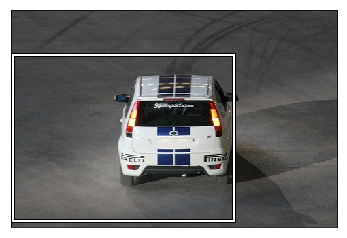

In [47]:
ax = show_img(im)
b = bb_2_hw(a_img[0])
print(b)
draw_rect(ax, b)
draw_txt(ax, b[:2], cats[a_img[1]])